# Reuters 딥러닝 모델

## 데이터 로드 및 전처리
reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다. 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [9]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print('train :',len(train_data))
print('val :',len(val_data))
print('test :',len(test_data))
print('label :',len(set(train_labels)))

train : 6736
val : 2246
test : 2246
label : 46


In [10]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
from tensorflow.keras import utils

y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

## 모델 구성 및 컴파일
BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.

In [11]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

input_shape = (x_train.shape[1], )

# 딥러닝 모델 구성
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())  # BatchNormalization 추가
model.add(Dropout(0.5))  # Dropout 추가
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # BatchNormalization 추가
model.add(Dropout(0.5))  # Dropout 추가
model.add(Dense(46, activation='softmax'))  # 출력 뉴런 개수를 클래스 개수(46)로 설정하고 Softmax 활성화 함수 사용

# 모델 컴파일
model.compile(loss='categorical_crossentropy',  # 다중 클래스 분류 문제이므로 categorical_crossentropy를 사용
              optimizer='adam',
              metrics=['accuracy'])  # 평가 지표로 정확도를 사용

# 모델 구조 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)               

## 모델 학습
ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/100
211/211 [==============================] - 2s 7ms/step - loss: 2.2295 - accuracy: 0.5349 - val_loss: 1.6260 - val_accuracy: 0.7102

Epoch 00001: val_loss improved from inf to 1.62598, saving model to best_model.h5
Epoch 2/100
211/211 [==============================] - 1s 5ms/step - loss: 1.2981 - accuracy: 0.7187 - val_loss: 1.1162 - val_accuracy: 0.7636

Epoch 00002: val_loss improved from 1.62598 to 1.11620, saving model to best_model.h5
Epoch 3/100
211/211 [==============================] - 1s 5ms/step - loss: 1.0310 - accuracy: 0.7645 - val_loss: 1.0224 - val_accuracy: 0.7863

Epoch 00003: val_loss improved from 1.11620 to 1.02236, saving model to best_model.h5
Epoch 4/100
211/211 [==============================] - 1s 5ms/step - loss: 0.8279 - accuracy: 0.8072 - val_loss: 0.9883 - val_accuracy: 0.7988

Epoch 00004: val_loss improved from 1.02236 to 0.98827, saving model to best_model.h5
Epoch 5/100
211/211 [==============================] - 1s 5ms/step - loss: 0.7037 - 

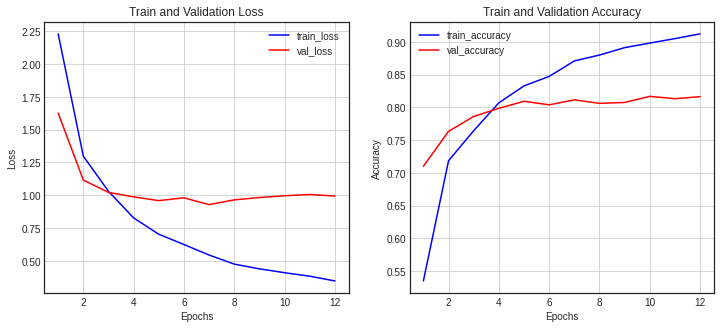

In [13]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측
테스트 데이터셋을 이용해 모델을 평가합니다.

In [14]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
loss, accuracy = model.evaluate(x_test, y_test)
print(f"테스트 데이터 정확도: {accuracy}")

71/71 [==============================] - 0s 3ms/step - loss: 1.0425 - accuracy: 0.7912
테스트 데이터 정확도: 0.7911843061447144
